In [1]:
import numpy as np
import os
import pandas as pd
import pyodbc
import time
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from datetime import datetime
import sys
import gc
from scipy.sparse import csr_matrix
import pickle
import joblib
from itertools import product
import matplotlib

In [2]:
data_path = '../prediction_data/'

### Read in population and visit data

In [3]:
num_days_prediction = 90
df_pop = pd.read_csv(data_path+'population.csv')
df_pop.rename({'psychosis_dx_date':'psychosis_diagnosis_date'}, axis=1, inplace=True)
df_pop['psychosis_diagnosis_date'] = pd.to_datetime(df_pop['psychosis_diagnosis_date'], format="%Y-%m-%d")
df_pop['cohort_start_date'] = pd.to_datetime(df_pop['cohort_start_date'])
df_pop = df_pop.loc[(df_pop['cohort_start_date']-df_pop['psychosis_diagnosis_date']).dt.days >= num_days_prediction]

In [4]:
all_visits = pd.read_csv(data_path+'temporal_visits.csv')
df_pop = df_pop.merge(all_visits.groupby('person_id').min()['visit_start_date'], how='left', left_on='person_id',right_index=True)
df_pop.rename({'visit_start_date':'first_visit'}, axis=1, inplace=True)
df_pop.head()

,Unnamed: 0,cohort_definition_id,person_id,cohort_start_date,end_date,year_of_birth,race_concept_id,gender_concept_id,scz_diagnosis_date,psychosis_diagnosis_date,age_diagnosis,sz_flag,first_visit
0,0,4149,20000716660,2017-12-31,2017-12-31 00:00:00,2001-01-01,8516,8507,NaN,2011-01-14,17.008219,0,2008-05-12
1,4,4149,20000727283,2016-06-30,2016-06-30 00:00:00,1997-01-01,8527,8507,NaN,2014-12-08,19.506849,0,2008-01-10
2,9,4149,20000742581,2017-12-31,2017-12-31 00:00:00,2002-01-01,8527,8507,NaN,2017-02-10,16.008219,0,2008-08-05
3,15,4149,20000750680,2017-12-31,2017-12-31 00:00:00,2001-01-01,8527,8532,NaN,2017-05-31,17.008219,0,2008-01-09
4,20,4149,20000756345,2017-12-31,2017-12-31 00:00:00,1987-01-01,8516,8507,NaN,2011-12-17,31.019178,0,2008-01-01


In [5]:
all_visits = all_visits.loc[all_visits['person_id'].isin(df_pop['person_id'])]
all_visits['cohort_start_date'] = pd.to_datetime(all_visits['cohort_start_date'])
all_visits['visit_start_date'] = pd.to_datetime(all_visits['visit_start_date'])
all_visits['visit_end_date'] = pd.to_datetime(all_visits['visit_end_date'])
all_visits['psychosis_diagnosis_date'] = pd.to_datetime(all_visits['psychosis_diagnosis_date'])

all_visits = all_visits.loc[(all_visits['cohort_start_date']-all_visits['visit_end_date']).dt.days >= num_days_prediction]
all_visits['days_to_cohort_start'] = (all_visits['cohort_start_date']-all_visits['visit_start_date']).dt.days

### Create sorted visits dataframe

In [6]:
sorted_visits = all_visits.groupby('person_id').apply(pd.DataFrame.sort_values, ['visit_start_date'])
sorted_visits.reset_index(drop=True, inplace=True)
sorted_visits = sorted_visits.merge(df_pop[['person_id', 'first_visit']], how = 'left', left_on = 'person_id', right_on = 'person_id')
sorted_visits = sorted_visits[['person_id', 'psychosis_diagnosis_date', 'first_visit', 'visit_start_date', 'cohort_start_date']].drop_duplicates()
sorted_visits = sorted_visits.loc[(sorted_visits['visit_start_date']>sorted_visits['psychosis_diagnosis_date'])]

In [7]:
nth_visit = np.asarray(sorted_visits.groupby('person_id').cumcount())
sorted_visits['nth_visit'] = nth_visit

In [8]:
sorted_visits['years to diagnosis'] = (sorted_visits['cohort_start_date']-sorted_visits['psychosis_diagnosis_date']).dt.days/365
max_visits = sorted_visits.groupby('person_id').max()[['nth_visit', 'years to diagnosis']]
max_visits['visits_per_year'] = max_visits['nth_visit']/max_visits['years to diagnosis']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


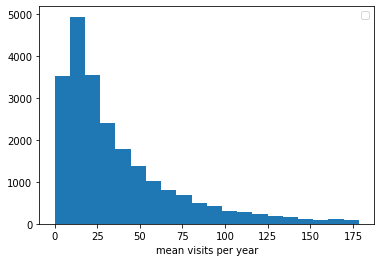

Median visits per year 26.120977895788766
Number of patients with outlier visits per year 984


In [9]:
q3 = np.quantile(max_visits['visits_per_year'], 0.75)
q1 = np.quantile(max_visits['visits_per_year'], 0.25)
outlier_top = q3 + 3*(q3-q1)


plt.hist(max_visits['visits_per_year'], bins = 20, range = (0,outlier_top))
plt.xlabel('mean visits per year')
plt.legend()
plt.show()
print('Median visits per year', max_visits['visits_per_year'].median())
print('Number of patients with outlier visits per year', sum(max_visits['visits_per_year']>outlier_top))

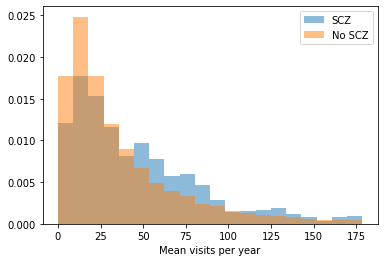

26.120977895788766
984


In [10]:
max_visits_by_outcome = max_visits.merge(df_pop[['person_id', 'sz_flag']], how='inner', left_index = True, right_on='person_id')
max_visits_scz = max_visits_by_outcome.loc[max_visits_by_outcome['sz_flag']==1]
max_visits_noscz = max_visits_by_outcome.loc[max_visits_by_outcome['sz_flag']==0]

plt.hist(max_visits_scz['visits_per_year'], bins = 20, range = (0,outlier_top), alpha=0.5, density=True, label = 'SCZ')
plt.hist(max_visits_noscz['visits_per_year'], bins = 20, range = (0,outlier_top), alpha=0.5, density=True, label = 'No SCZ')
plt.legend()
plt.xlabel('Mean visits per year')
plt.show()
print(max_visits['visits_per_year'].median())
print(sum(max_visits['visits_per_year']>outlier_top))


### for each patient, what is the median number of days between visits if we chunk at every 6?

In [13]:
check_dates = sorted_visits.copy()
check_dates = check_dates.loc[check_dates['nth_visit']%8==0]
check_dates['date shift'] = check_dates['visit_start_date'].shift(1)
check_dates = check_dates.loc[check_dates['nth_visit']>0]
check_dates['days_between_visits'] = (check_dates['visit_start_date']-check_dates['date shift']).dt.days
time_between_visits = check_dates.groupby('person_id').agg({'days_between_visits': ['min','max','mean','median']})
time_between_visits['days_between_visits']['mean'].mean(), check_dates['days_between_visits'].mean()
print('Median of the days between visits per person', time_between_visits['days_between_visits']['median'].median())
print('Median days between visits', check_dates['days_between_visits'].median())

Median of the days between visits per person 61.0
Median days between visits 20.0
